## RNN의 문제점

### RNN 복습

###  기울기 소실 또는 기울기 폭발

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
N = 2
H = 3
T = 20

dh = np.ones((N,H))
np.random.seed(3)
Wh = np.random.randn(H,H)
norm_list = []
for t in range(T):
    dh = np.matmul(dh,Wh.T)
    norm = np.sqrt(np.sum(dh**2))/N
    norm_list.append(norm)

<IPython.core.display.Javascript object>


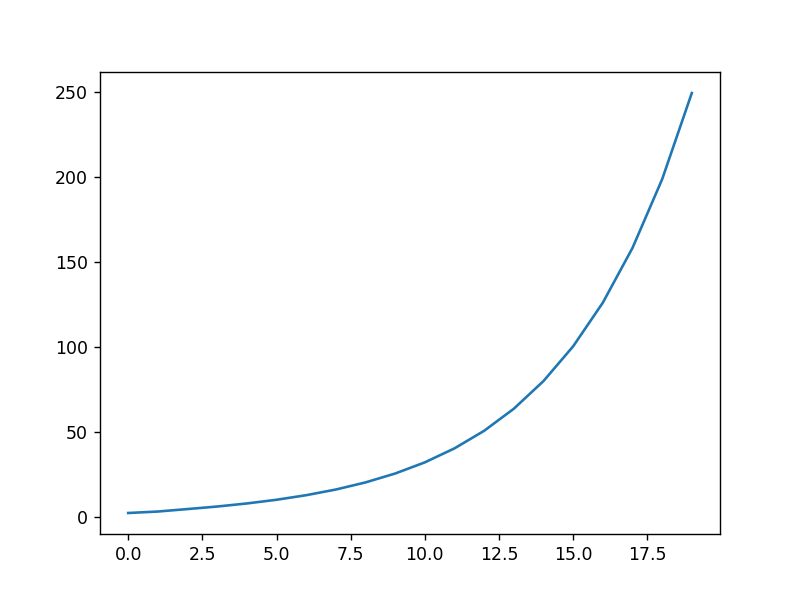

In [5]:
plt.plot(norm_list) # 기울기 폭발

### 기울기 폭발 대책
- 기울기 클리핑

In [6]:
dW1 = np.random.rand(3,3) * 10
dW2 = np.random.rand(3,3) * 10
grads = [dW1,dW2]
max_norm = 5.0

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad**2)
    total_norm = np.sqrt(total_norm)
    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

## 기울기 소실과 LSTM

### output gate

## LSTM 구현

In [9]:
import sys
sys.path.append('deep2')
from common.functions import sigmoid

In [10]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx),np.zeros_like(Wh),np.zeros_like(b)]
        self.cache = None
    
    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        A = np.matmul(x,Wx) + np.matmul(h_prev, Wh) + b
        
        f = A[:,:H]
        g = A[:,H:2*H]
        i = A[:,2*H:3*H]
        o = A[:,3*H:]
        
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

## Time LSTM

In [11]:
from common.time_layers import LSTM

In [29]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(i) for i in [Wx, Wh, b]]
        self.layers = None
        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]
        self.layers = []
        hs = np.empty((N,T,H),dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N,H),dtype = 'f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N,H),dtype='f')
        
        for t in range(T):
            layer = LSTM(Wx,Wh,b)
            self.h, self.c = layer.forward(xs[:,t,:], self.h, self.c)
            hs[:,t,:] = self.h
            self.layers.append(layer)
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]
        dxs = np.empty((N,T,D),dtype='f')
        dh, dc = 0,0
        grads = [0,0,0]
        
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:,t,:] + dh, dc)
            dxs[:,t,:] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs
    
    def set_state(self, h, c=None):
        self.h, self.c = h, c
        
    def reset_state(self):
        self.h, self.c = None, None

### LSTM을 이용한 언어모델

In [15]:
import pickle
from common.time_layers import TimeEmbedding, TimeAffine,TimeSoftmaxWithLoss

In [32]:
class Rnnlm:
    def __init__(self, vocab_size=10000,wordvec_size=100,hidden_size = 100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.rand
        
        embed_W = (rn(V,D)/100).astype('f')
        lstm_Wx = (rn(D, 4*H)/np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4*H)/np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        affine_W = (rn(H,V)/np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.layers = [
            TimeEmbedding(embed_W)
            ,TimeLSTM(lstm_Wx, lstm_Wh, lstm_b,stateful=True)
            ,TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]
        
        self.params, self.grads = [],[]
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
        
    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout =1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.lstm_layer.reset_state()
        
    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
    
    def load_params(self, file_name = 'Rnnlm.pkl'):
        with open(file_name,'rb') as f:
            self.params = pickle.load(f)

In [17]:
# 학습
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
# from deep2.ch06.rnnlm import Rnnlm

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 10223.53
| 에폭 1 |  반복 21 / 1327 | 시간 7[s] | 퍼플렉서티 286848.39
| 에폭 1 |  반복 41 / 1327 | 시간 15[s] | 퍼플렉서티 1804.20
| 에폭 1 |  반복 61 / 1327 | 시간 23[s] | 퍼플렉서티 1162.19
| 에폭 1 |  반복 81 / 1327 | 시간 31[s] | 퍼플렉서티 929.27
| 에폭 1 |  반복 101 / 1327 | 시간 38[s] | 퍼플렉서티 786.76
| 에폭 1 |  반복 121 / 1327 | 시간 45[s] | 퍼플렉서티 800.73
| 에폭 1 |  반복 141 / 1327 | 시간 53[s] | 퍼플렉서티 740.90
| 에폭 1 |  반복 161 / 1327 | 시간 61[s] | 퍼플렉서티 731.60
| 에폭 1 |  반복 181 / 1327 | 시간 69[s] | 퍼플렉서티 720.37
| 에폭 1 |  반복 201 / 1327 | 시간 76[s] | 퍼플렉서티 628.70
| 에폭 1 |  반복 221 / 1327 | 시간 84[s] | 퍼플렉서티 628.34
| 에폭 1 |  반복 241 / 1327 | 시간 92[s] | 퍼플렉서티 563.69
| 에폭 1 |  반복 261 / 1327 | 시간 99[s] | 퍼플렉서티 601.78
| 에폭 1 |  반복 281 / 1327 | 시간 107[s] | 퍼플렉서티 589.00
| 에폭 1 |  반복 301 / 1327 | 시간 115[s] | 퍼플렉서티 505.39
| 에폭 1 |  반복 321 / 1327 | 시간 123[s] | 퍼플렉서티 456.61
| 에폭 1 |  반복 341 / 1327 | 시간 131[s] | 퍼플렉서티 514.65
| 에폭 1 |  반복 361 / 1327 | 시간 138[s] | 퍼플렉서티 512.58
| 에폭 1 |  반복 381 / 1327 | 시간 146[s] | 퍼플렉서티 44

| 에폭 3 |  반복 521 / 1327 | 시간 1241[s] | 퍼플렉서티 163.54
| 에폭 3 |  반복 541 / 1327 | 시간 1249[s] | 퍼플렉서티 163.67
| 에폭 3 |  반복 561 / 1327 | 시간 1257[s] | 퍼플렉서티 146.89
| 에폭 3 |  반복 581 / 1327 | 시간 1265[s] | 퍼플렉서티 133.83
| 에폭 3 |  반복 601 / 1327 | 시간 1272[s] | 퍼플렉서티 183.65
| 에폭 3 |  반복 621 / 1327 | 시간 1280[s] | 퍼플렉서티 173.24
| 에폭 3 |  반복 641 / 1327 | 시간 1288[s] | 퍼플렉서티 157.44
| 에폭 3 |  반복 661 / 1327 | 시간 1295[s] | 퍼플렉서티 147.33
| 에폭 3 |  반복 681 / 1327 | 시간 1303[s] | 퍼플렉서티 122.38
| 에폭 3 |  반복 701 / 1327 | 시간 1311[s] | 퍼플렉서티 144.73
| 에폭 3 |  반복 721 / 1327 | 시간 1319[s] | 퍼플렉서티 154.76
| 에폭 3 |  반복 741 / 1327 | 시간 1327[s] | 퍼플렉서티 130.00
| 에폭 3 |  반복 761 / 1327 | 시간 1335[s] | 퍼플렉서티 130.29
| 에폭 3 |  반복 781 / 1327 | 시간 1342[s] | 퍼플렉서티 126.37
| 에폭 3 |  반복 801 / 1327 | 시간 1350[s] | 퍼플렉서티 141.47
| 에폭 3 |  반복 821 / 1327 | 시간 1357[s] | 퍼플렉서티 139.08
| 에폭 3 |  반복 841 / 1327 | 시간 1365[s] | 퍼플렉서티 139.23
| 에폭 3 |  반복 861 / 1327 | 시간 1373[s] | 퍼플렉서티 144.88
| 에폭 3 |  반복 881 / 1327 | 시간 1381[s] | 퍼플렉서티 128.98
| 에폭 3 |  반복

<IPython.core.display.Javascript object>


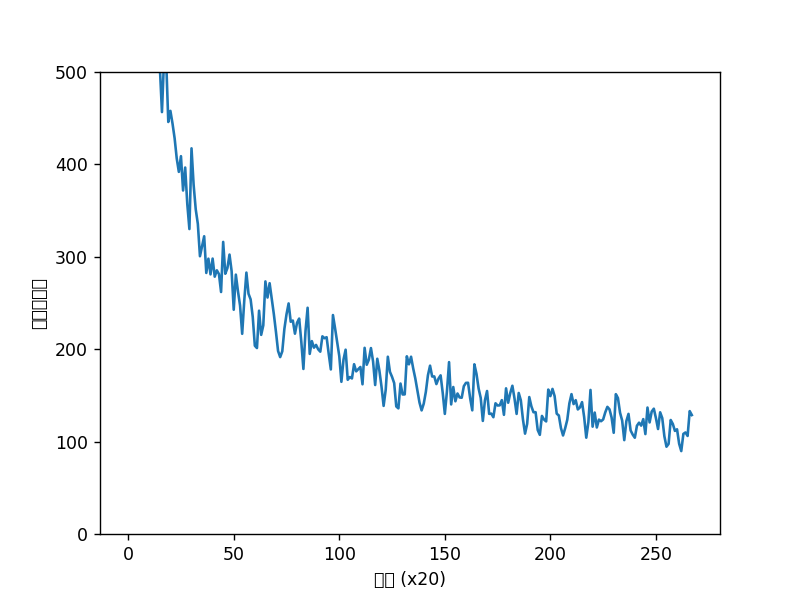

In [30]:
batch_size = 20
wordvec_size = 100
hidden_size = 100
time_size = 35
lr = 20.0
max_epoch = 4
max_grad = 0.25

corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]
model = Rnnlm(vocab_size,wordvec_size,hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs,ts,max_epoch,batch_size,time_size,max_grad,eval_interval=20)
plt.figure()
trainer.plot(ylim=(0,500))

In [36]:
# 테스트
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

퍼플렉서티 평가 중 ...
234 / 235
test perplexity:  143.5348522643565


In [35]:
file_name = 'Rnnlm.pkl'
with open(file_name, 'wb') as f:
    pickle.dump(model.params, f)

## RNNLM 개선

### LSTM 계층화
- RNN 층을 더 쌓는다.

### dropout
- 일반적인 dropout : 상하방향만 효과있음(RNN -> affine)
- 변형 dropout(마스크 공유) : 시계열 방향으로 사용가능

### 가중치 공유

### 개선된 RNNLM 구현
- 2층의 LSTM
- 상하 방향의 dropout
- affine, embeding layer weight tying

In [37]:
from common.time_layers import *
from common.np import *
from common.base_model import BaseModel

In [43]:
class BetterRnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=650,hidden_size=650,dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V,D)/100).astype('f')
        lstm_Wx1 = (rn(D, 4*H)/np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4*H)/np.sqrt(D)).astype('f')
        lstm_b1 = np.zeros(4*H).astype('f')
        lstm_Wx2 = (rn(H, 4*H)/np.sqrt(D)).astype('f')
        lstm_Wh2 = (rn(H, 4*H)/np.sqrt(D)).astype('f')
        lstm_b2 = np.zeros(4*H).astype('f')
        affine_b = np.zeros(V)
        
        self.layers = [
            TimeEmbedding(embed_W)
            ,TimeDropout(dropout_ratio)
            ,TimeLSTM(lstm_Wx1,lstm_Wh1,lstm_b1,stateful=True)
            ,TimeDropout(dropout_ratio)
            ,TimeLSTM(lstm_Wx2,lstm_Wh2,lstm_b2,stateful=True)
            ,TimeDropout(dropout_ratio)
            ,TimeAffine(embed_W.T,affine_b)
        ]
        
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2],self.layers[4]]
        self.drop_layers = [self.layers[1],self.layers[3],self.layers[5]]
        
        self.params,self.grads = [],[]
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

In [ ]:
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('검증 퍼플렉서티: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)

| 에폭 1 |  반복 1 / 1327 | 시간 6[s] | 퍼플렉서티 10000.14
| 에폭 1 |  반복 21 / 1327 | 시간 115[s] | 퍼플렉서티 4066.67


In [ ]:
# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)